In [1]:
!pip freeze

asn1crypto==1.3.0
atomicwrites==1.3.0
attrs==19.3.0
backcall==0.1.0
beautifulsoup4==4.8.2
bleach==3.1.0
blis==0.4.1
boto3==1.12.30
botocore==1.15.30
catalogue==1.0.0
certifi==2020.4.5.1
cffi==1.14.0
chardet==3.0.4
click==7.1.1
click-plugins==1.1.1
cligj==0.5.0
cloudpickle==1.3.0
colorama==0.4.3
cryptography==2.8
cycler==0.10.0
cymem==2.0.3
cytoolz==0.10.1
dask==2.14.0
decorator==4.4.1
defusedxml==0.6.0
docutils==0.15.2
elasticsearch==7.0.4
entrypoints==0.3
feedparser==5.2.1
Fiona==1.8.4
Flask==1.1.1
GDAL==2.3.3
geographiclib==1.50
geopandas==0.6.1
geopy==1.21.0
idna==2.9
imageio==2.8.0
importlib-metadata==1.5.0
importlib-resources==1.4.0
ipykernel==5.1.4
ipython==7.12.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
itsdangerous==1.1.0
jedi==0.16.0
Jinja2==2.11.1
jmespath==0.9.5
joblib==0.14.1
json5==0.9.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==5.3.4
jupyter-console==6.1.0
jupyter-core==4.6.1
jupyterlab==2.0.1
jupyterlab-server==1.0.7
kiwisolver==1.0.1
lightgbm==2.3.0
llvmlite==0.

# Imports

In [1]:
# Standard libs
import math
import logging
import re
import json
import itertools
from io import StringIO
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import progressbar

# Science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# ML specific
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Extras
from bs4 import BeautifulSoup, SoupStrainer
import sys
import string
import requests
import datetime
import progressbar
import time
import lxml

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


# Change 
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Setup viz
%matplotlib inline

TM_pal_primary = ['#ef4631', '#020202', '#3c3a3b', '#b4b4b4']

TM_pal_sequential_terr = ['#fff8ef', '#ffcc99', '#fb8a5f', '#e75031', '#c30202']
TM_pal_sequential_tund = ['#f0f0f0', '#bfbebe', '#918f90', '#656363', '#3c3a3b']

TM_pal_divergent_tc = ['#10b9ce', '#a6d9de', '#fff8ef', '#ffa68e', '#ef4631']
TM_pal_divergent_tt = ['#3c3a3b', '#989390', '#fff8ef', '#ffa68e', '#ef4631']

TM_pal_categorical_3 = ['#ef4631', '#10b9ce', '#ff9138']
TM_pal_categorical_5 = ['#ef4631', '#10b9ce', '#72dde9', '#ff9138', '#ffb478']
TM_pal_categorical_10 = ['#ef4631', '#f47f71', '#10b9ce', '#72dde9', '#2292ec',
                         '#66b4f2', '#ff9138', '#ffb478', '#3f50b0', '#7a86c8']

sns.set(style='white',
        palette=TM_pal_categorical_3,
        rc={'axes.edgecolor': TM_pal_primary[3],
            'axes.spines.top': False,
            'axes.spines.right': False,
            'font.family': ['sans-serif'],
            'font.sans-serif': ['Helvetica Neue'],
            'font.weight': 'light', # Can be medium or light
            'grid.alpha': 0.5,
            'grid.color': TM_pal_primary[3],
            'text.color': TM_pal_primary[1],
            'xtick.color': TM_pal_primary[1],
            'xtick.labelsize': 13,
            'ytick.color': TM_pal_primary[1],
            'ytick.labelsize': 13})

# Data

In [4]:
# Read
df_raw = pd.read_csv('../data/df_lags_2018.csv')
df_raw.head()

,index,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,home_result,away_result,home_pts_differential,away_pts_differential,total_pts,home_win_cumsum,home_game_number,home_win_percentage_cumsum,away_win_cumsum,away_game_number,away_win_percentage_cumsum,scored_1_home,allowed_1_home,result_1_home,pts_differential_1_home,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,time_delta_1_home,time_delta_cumsum_1_home,timezone_diff_1_home,timezone_diff_cumsum_1_home,scored_2_home,allowed_2_home,result_2_home,pts_differential_2_home,game_number_2_home,win_cumsum_2_home,win_percentage_cumsum_2_home,time_delta_2_home,time_delta_cumsum_2_home,timezone_diff_2_home,timezone_diff_cumsum_2_home,scored_3_home,allowed_3_home,result_3_home,pts_differential_3_home,game_number_3_home,win_cumsum_3_home,win_percentage_cumsum_3_home,time_delta_3_home,time_delta_cumsum_3_home,timezone_diff_3_home,timezone_diff_cumsum_3_home,scored_4_home,allowed_4_home,result_4_home,pts_differential_4_home,game_number_4_home,win_cumsum_4_home,win_percentage_cumsum_4_home,time_delta_4_home,time_delta_cumsum_4_home,timezone_diff_4_home,timezone_diff_cumsum_4_home,scored_1_away,allowed_1_away,result_1_away,pts_differential_1_away,game_number_1_away,win_cumsum_1_away,win_percentage_cumsum_1_away,time_delta_1_away,time_delta_cumsum_1_away,timezone_diff_1_away,timezone_diff_cumsum_1_away,scored_2_away,allowed_2_away,result_2_away,pts_differential_2_away,game_number_2_away,win_cumsum_2_away,win_percentage_cumsum_2_away,time_delta_2_away,time_delta_cumsum_2_away,timezone_diff_2_away,timezone_diff_cumsum_2_away,scored_3_away,allowed_3_away,result_3_away,pts_differential_3_away,game_number_3_away,win_cumsum_3_away,win_percentage_cumsum_3_away,time_delta_3_away,time_delta_cumsum_3_away,timezone_diff_3_away,timezone_diff_cumsum_3_away,scored_4_away,allowed_4_away,result_4_away,pts_differential_4_away,game_number_4_away,win_cumsum_4_away,win_percentage_cumsum_4_away,time_delta_4_away,time_delta_cumsum_4_away,timezone_diff_4_away,timezone_diff_cumsum_4_away,scored_1_home_home,allowed_1_home_home,result_1_home_home,pts_differential_1_home_home,game_number_1_home_home,win_cumsum_1_home_home,win_percentage_cumsum_1_home_home,time_delta_1_home_home,time_delta_cumsum_1_home_home,timezone_diff_1_home_home,timezone_diff_cumsum_1_home_home,scored_2_home_home,allowed_2_home_home,result_2_home_home,pts_differential_2_home_home,game_number_2_home_home,win_cumsum_2_home_home,win_percentage_cumsum_2_home_home,time_delta_2_home_home,time_delta_cumsum_2_home_home,timezone_diff_2_home_home,timezone_diff_cumsum_2_home_home,scored_3_home_home,allowed_3_home_home,result_3_home_home,pts_differential_3_home_home,game_number_3_home_home,win_cumsum_3_home_home,win_percentage_cumsum_3_home_home,time_delta_3_home_home,time_delta_cumsum_3_home_home,timezone_diff_3_home_home,timezone_diff_cumsum_3_home_home,scored_4_home_home,allowed_4_home_home,result_4_home_home,pts_differential_4_home_home,game_number_4_home_home,win_cumsum_4_home_home,win_percentage_cumsum_4_home_home,time_delta_4_home_home,time_delta_cumsum_4_home_home,timezone_diff_4_home_home,timezone_diff_cumsum_4_home_home,scored_1_away_away,allowed_1_away_away,result_1_away_away,pts_differential_1_away_away,game_number_1_away_away,win_cumsum_1_away_away,win_percentage_cumsum_1_away_away,time_delta_1_away_away,time_delta_cumsum_1_away_away,timezone_diff_1_away_away,timezone_diff_cumsum_1_away_away,scored_2_away_away,allowed_2_away_away,result_2_away_away,pts_differential_2_away_away,game_number_2_away_away,win_cumsum_2_away_away,win_percentage_cumsum_2_away_away,time_delta_2_away_away,time_delta_cumsum_2_away_away,timezone_diff_2_away_away,timezone_diff_cumsum_2_away_away,scored_3_away_away,allowed_3_away_away,result_3_away_away,pts_differential_3_away_away,game_number_3_away_away,win_cumsum_3_away_away,win_percentage_cumsum_3_away_away,time_delta_3_away_away,time_delta_cumsum_3_away_away,timezo

# Transformations

In [5]:
def zscorer(x):
    return (x - x.mean())/x.std()

In [5]:
def feature_selector(feature_set):
    """
    Return list of features, given a feature set name.
    
    Inputs:
    feature_set: (string) Name of feature set.
    
    """
    
    # Feature Set 01 - Long term dynamic features + aggregated lagged features
    if feature_set == 'feature_set_01':
        features = [
        # Long term dynamic features
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_percentage_cumsum_1_away',
        'win_cumsum_1_away',

        # Lagged features (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away',
        'agg_scored_4_lags_home_home',
        'agg_allowed_4_lags_home_home',
        'agg_pts_differential_4_lags_home_home',
        'agg_total_pts_4_lags_home_home',
        'agg_win_rate_4_lags_home_home',
        'agg_scored_4_lags_away_away',
        'agg_allowed_4_lags_away_away',
        'agg_pts_differential_4_lags_away_away',
        'agg_total_pts_4_lags_away_away',
        'agg_win_rate_4_lags_away_away',
        'agg_time_delta_cumsum_4_lags_away_away',
        'agg_timezone_diff_cumsum_4_lags_away_away',
        ]
        
        
    # Feature Set 02 - Long term dynamic features including side-specific + aggregated lagged features
    if feature_set == 'feature_set_02':
        features = [
        
        # Non-lagged dynamic features     
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_cumsum_1_away',
        'win_percentage_cumsum_1_away',
        'game_number_1_home_home',
        'win_cumsum_1_home_home',
        'win_percentage_cumsum_1_home_home',
        'game_number_1_away_away',
        'win_cumsum_1_away_away',
        'win_percentage_cumsum_1_away_away',
            
        # Lagged features (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away',
        'agg_scored_4_lags_home_home',
        'agg_allowed_4_lags_home_home',
        'agg_pts_differential_4_lags_home_home',
        'agg_total_pts_4_lags_home_home',
        'agg_win_rate_4_lags_home_home',
        'agg_scored_4_lags_away_away',
        'agg_allowed_4_lags_away_away',
        'agg_pts_differential_4_lags_away_away',
        'agg_total_pts_4_lags_away_away',
        'agg_win_rate_4_lags_away_away',
        'agg_time_delta_cumsum_4_lags_away_away',
        'agg_timezone_diff_cumsum_4_lags_away_away',
        ]
        
        
    # Feature Set 02 - Long term dynamic features including side-specific 
    # + raw lagged features + aggregated lagged features
    if feature_set == "feature_set_03":
        features = [
        # Non-lagged dynamic features     
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_cumsum_1_away',
        'win_percentage_cumsum_1_away',
        'game_number_1_home_home',
        'win_cumsum_1_home_home',
        'win_percentage_cumsum_1_home_home',
        'game_number_1_away_away',
        'win_cumsum_1_away_away',
        'win_percentage_cumsum_1_away_away',


        # Lagged features (raw)
        'scored_1_home',
        'allowed_1_home',
        'result_1_home',
        'pts_differential_1_home',
        'time_delta_1_home',
        'time_delta_cumsum_1_home',
        'timezone_diff_1_home',
        'timezone_diff_cumsum_1_home',
        'scored_2_home',
        'allowed_2_home',
        'result_2_home',
        'pts_differential_2_home',
        'game_number_2_home',
        'win_cumsum_2_home',
        'win_percentage_cumsum_2_home',
        'time_delta_2_home',
        'time_delta_cumsum_2_home',
        'timezone_diff_2_home',
        'timezone_diff_cumsum_2_home',
        'scored_3_home',
        'allowed_3_home',
        'result_3_home',
        'pts_differential_3_home',
        'game_number_3_home',
        'win_cumsum_3_home',
        'win_percentage_cumsum_3_home',
        'time_delta_3_home',
        'time_delta_cumsum_3_home',
        'timezone_diff_3_home',
        'timezone_diff_cumsum_3_home',
        'scored_4_home',
        'allowed_4_home',
        'result_4_home',
        'pts_differential_4_home',
        'game_number_4_home',
        'win_cumsum_4_home',
        'win_percentage_cumsum_4_home',
        'time_delta_4_home',
        'time_delta_cumsum_4_home',
        'timezone_diff_4_home',
        'timezone_diff_cumsum_4_home',
        'scored_1_away',
        'allowed_1_away',
        'result_1_away',
        'pts_differential_1_away',
        'time_delta_1_away',
        'time_delta_cumsum_1_away',
        'timezone_diff_1_away',
        'timezone_diff_cumsum_1_away',
        'scored_2_away',
        'allowed_2_away',
        'result_2_away',
        'pts_differential_2_away',
        'game_number_2_away',
        'win_cumsum_2_away',
        'win_percentage_cumsum_2_away',
        'time_delta_2_away',
        'time_delta_cumsum_2_away',
        'timezone_diff_2_away',
        'timezone_diff_cumsum_2_away',
        'scored_3_away',
        'allowed_3_away',
        'result_3_away',
        'pts_differential_3_away',
        'game_number_3_away',
        'win_cumsum_3_away',
        'win_percentage_cumsum_3_away',
        'time_delta_3_away',
        'time_delta_cumsum_3_away',
        'timezone_diff_3_away',
        'timezone_diff_cumsum_3_away',
        'scored_4_away',
        'allowed_4_away',
        'result_4_away',
        'pts_differential_4_away',
        'game_number_4_away',
        'win_cumsum_4_away',
        'win_percentage_cumsum_4_away',
        'time_delta_4_away',
        'time_delta_cumsum_4_away',
        'timezone_diff_4_away',
        'timezone_diff_cumsum_4_away',
        'scored_1_home_home',
        'allowed_1_home_home',
        'result_1_home_home',
        'pts_differential_1_home_home',
        'scored_2_home_home',
        'allowed_2_home_home',
        'result_2_home_home',
        'pts_differential_2_home_home',
        'game_number_2_home_home',
        'win_cumsum_2_home_home',
        'win_percentage_cumsum_2_home_home',
        'scored_3_home_home',
        'allowed_3_home_home',
        'result_3_home_home',
        'pts_differential_3_home_home',
        'game_number_3_home_home',
        'win_cumsum_3_home_home',
        'win_percentage_cumsum_3_home_home',
        'scored_4_home_home',
        'allowed_4_home_home',
        'result_4_home_home',
        'pts_differential_4_home_home',
        'game_number_4_home_home',
        'win_cumsum_4_home_home',
        'win_percentage_cumsum_4_home_home',
        'scored_1_away_away',
        'allowed_1_away_away',
        'result_1_away_away',
        'pts_differential_1_away_away',
        'scored_2_away_away',
        'allowed_2_away_away',
        'result_2_away_away',
        'pts_differential_2_away_away',
        'game_number_2_away_away',
        'win_cumsum_2_away_away',
        'win_percentage_cumsum_2_away_away',
        'scored_3_away_away',
        'allowed_3_away_away',
        'result_3_away_away',
        'pts_differential_3_away_away',
        'game_number_3_away_away',
        'win_cumsum_3_away_away',
        'win_percentage_cumsum_3_away_away',
        'scored_4_away_away',
        'allowed_4_away_away',
        'result_4_away_away',
        'pts_differential_4_away_away',
        'game_number_4_away_away',
        'win_cumsum_4_away_away',
        'win_percentage_cumsum_4_away_away',

        # Lagged features (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away',
        'agg_scored_4_lags_home_home',
        'agg_allowed_4_lags_home_home',
        'agg_pts_differential_4_lags_home_home',
        'agg_total_pts_4_lags_home_home',
        'agg_win_rate_4_lags_home_home',
        'agg_scored_4_lags_away_away',
        'agg_allowed_4_lags_away_away',
        'agg_pts_differential_4_lags_away_away',
        'agg_total_pts_4_lags_away_away',
        'agg_win_rate_4_lags_away_away',
        'agg_time_delta_cumsum_4_lags_away_away',
        'agg_timezone_diff_cumsum_4_lags_away_away',
        ]
        
        
    # Feature Set 04 - Long term dynamic features including side-specific 
    # + aggregated lagged features
    # + projected season win rate
    if feature_set == 'feature_set_04':
        features = [    
        # Non-dynamic features (projected season win rate) 
        'home_projected_winloss',
        'away_projected_winloss',
            
        # Non-lagged dynamic features     
        'home_kde_lag20_prob',
        'game_number_1_home',
        'win_cumsum_1_home',
        'win_percentage_cumsum_1_home',
        'game_number_1_away',
        'win_cumsum_1_away',
        'win_percentage_cumsum_1_away',
        'game_number_1_home_home',
        'win_cumsum_1_home_home',
        'win_percentage_cumsum_1_home_home',
        'game_number_1_away_away',
        'win_cumsum_1_away_away',
        'win_percentage_cumsum_1_away_away',
            
        # Lagged features (aggregated)
        'agg_scored_4_lags_home',
        'agg_allowed_4_lags_home',
        'agg_pts_differential_4_lags_home',
        'agg_total_pts_4_lags_home',
        'agg_win_rate_4_lags_home',
        'agg_time_delta_cumsum_4_lags_home',
        'agg_timezone_diff_cumsum_4_lags_home',
        'agg_scored_4_lags_away',
        'agg_allowed_4_lags_away',
        'agg_pts_differential_4_lags_away',
        'agg_total_pts_4_lags_away',
        'agg_win_rate_4_lags_away',
        'agg_time_delta_cumsum_4_lags_away',
        'agg_timezone_diff_cumsum_4_lags_away',
        'agg_scored_4_lags_home_home',
        'agg_allowed_4_lags_home_home',
        'agg_pts_differential_4_lags_home_home',
        'agg_total_pts_4_lags_home_home',
        'agg_win_rate_4_lags_home_home',
        'agg_scored_4_lags_away_away',
        'agg_allowed_4_lags_away_away',
        'agg_pts_differential_4_lags_away_away',
        'agg_total_pts_4_lags_away_away',
        'agg_win_rate_4_lags_away_away',
        'agg_time_delta_cumsum_4_lags_away_away',
        'agg_timezone_diff_cumsum_4_lags_away_away',
        ]
        
        
    return(features)

In [6]:
def feature_transformer(df_features, features, zscore=True):
    """
    Return transformed dataframe of features.
    
    Inputs:
    df_features: (pandas df) Dataframe that includes columns to be used as features.
    features: (list) List of columns to be considered as features.
    zscore: (bool) Whether to z-score features or not.
    """
    
    # Drop na's for feature colujmngs
    df_features_transformed = df_features.dropna(subset=features)

    # Zscore
    if zscore:
        for i in features:
            df_features_transformed[i] = zscorer(df_features_transformed[i])
        
    return(df_features_transformed)

In [358]:
# Example:
# Transform df
features = feature_selector("feature_set_01")
df_features_transformed = feature_transformer(df_raw, features)
df_features_transformed.head()

,index,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,home_result,away_result,home_pts_differential,away_pts_differential,total_pts,home_win_cumsum,home_game_number,home_win_percentage_cumsum,away_win_cumsum,away_game_number,away_win_percentage_cumsum,scored_1_home,allowed_1_home,result_1_home,pts_differential_1_home,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,time_delta_1_home,time_delta_cumsum_1_home,timezone_diff_1_home,timezone_diff_cumsum_1_home,scored_2_home,allowed_2_home,result_2_home,pts_differential_2_home,game_number_2_home,win_cumsum_2_home,win_percentage_cumsum_2_home,time_delta_2_home,time_delta_cumsum_2_home,timezone_diff_2_home,timezone_diff_cumsum_2_home,scored_3_home,allowed_3_home,result_3_home,pts_differential_3_home,game_number_3_home,win_cumsum_3_home,win_percentage_cumsum_3_home,time_delta_3_home,time_delta_cumsum_3_home,timezone_diff_3_home,timezone_diff_cumsum_3_home,scored_4_home,allowed_4_home,result_4_home,pts_differential_4_home,game_number_4_home,win_cumsum_4_home,win_percentage_cumsum_4_home,time_delta_4_home,time_delta_cumsum_4_home,timezone_diff_4_home,timezone_diff_cumsum_4_home,scored_1_away,allowed_1_away,result_1_away,pts_differential_1_away,game_number_1_away,win_cumsum_1_away,win_percentage_cumsum_1_away,time_delta_1_away,time_delta_cumsum_1_away,timezone_diff_1_away,timezone_diff_cumsum_1_away,scored_2_away,allowed_2_away,result_2_away,pts_differential_2_away,game_number_2_away,win_cumsum_2_away,win_percentage_cumsum_2_away,time_delta_2_away,time_delta_cumsum_2_away,timezone_diff_2_away,timezone_diff_cumsum_2_away,scored_3_away,allowed_3_away,result_3_away,pts_differential_3_away,game_number_3_away,win_cumsum_3_away,win_percentage_cumsum_3_away,time_delta_3_away,time_delta_cumsum_3_away,timezone_diff_3_away,timezone_diff_cumsum_3_away,scored_4_away,allowed_4_away,result_4_away,pts_differential_4_away,game_number_4_away,win_cumsum_4_away,win_percentage_cumsum_4_away,time_delta_4_away,time_delta_cumsum_4_away,timezone_diff_4_away,timezone_diff_cumsum_4_away,scored_1_home_home,allowed_1_home_home,result_1_home_home,pts_differential_1_home_home,game_number_1_home_home,win_cumsum_1_home_home,win_percentage_cumsum_1_home_home,time_delta_1_home_home,time_delta_cumsum_1_home_home,timezone_diff_1_home_home,timezone_diff_cumsum_1_home_home,scored_2_home_home,allowed_2_home_home,result_2_home_home,pts_differential_2_home_home,game_number_2_home_home,win_cumsum_2_home_home,win_percentage_cumsum_2_home_home,time_delta_2_home_home,time_delta_cumsum_2_home_home,timezone_diff_2_home_home,timezone_diff_cumsum_2_home_home,scored_3_home_home,allowed_3_home_home,result_3_home_home,pts_differential_3_home_home,game_number_3_home_home,win_cumsum_3_home_home,win_percentage_cumsum_3_home_home,time_delta_3_home_home,time_delta_cumsum_3_home_home,timezone_diff_3_home_home,timezone_diff_cumsum_3_home_home,scored_4_home_home,allowed_4_home_home,result_4_home_home,pts_differential_4_home_home,game_number_4_home_home,win_cumsum_4_home_home,win_percentage_cumsum_4_home_home,time_delta_4_home_home,time_delta_cumsum_4_home_home,timezone_diff_4_home_home,timezone_diff_cumsum_4_home_home,scored_1_away_away,allowed_1_away_away,result_1_away_away,pts_differential_1_away_away,game_number_1_away_away,win_cumsum_1_away_away,win_percentage_cumsum_1_away_away,time_delta_1_away_away,time_delta_cumsum_1_away_away,timezone_diff_1_away_away,timezone_diff_cumsum_1_away_away,scored_2_away_away,allowed_2_away_away,result_2_away_away,pts_differential_2_away_away,game_number_2_away_away,win_cumsum_2_away_away,win_percentage_cumsum_2_away_away,time_delta_2_away_away,time_delta_cumsum_2_away_away,timezone_diff_2_away_away,timezone_diff_cumsum_2_away_away,scored_3_away_away,allowed_3_away_away,result_3_away_away,pts_differential_3_away_away,game_number_3_away_away,win_cumsum_3_away_away,win_percentage_cumsum_3_away_away,time_delta_3_away_away,time_delta_cumsum_3_away_away,timezo

# Split

In [360]:
def splitter(df_features_transformed, features, index_list, cutoff_date_train, cutoff_date_test, cutoff_date_valid):
    """
    Split data into train, test, and validation sets.
    
    Inputs:
    df_features_transformed: (pandas df) Dataframe that includes (transformed) features.
    features: (list) List of columns to be considered as features.
    index_list: (list) List of columns to be considered as indices.
    cutoff_date_train: (string) First date of train set.
    cutoff_date_test: (string) Last date of train set, first date of test set.
    cutoff_date_valid: (string) Last date of test set, first date of validation set.
    
    """
    
    train = df_features_transformed[(df_features_transformed['year_month_day']>=cutoff_date_train) & (df_features_transformed['year_month_day']<cutoff_date_test)]
    test = df_features_transformed[(df_features_transformed['year_month_day'] >= cutoff_date_test) & (df_features_transformed['year_month_day']<cutoff_date_valid)]
    valid = df_features_transformed[df_features_transformed['year_month_day']>=cutoff_date_valid]
#     print('train shape: ', train.shape)
#     print('test shape: ', test.shape)
#     print('valid shape: ', valid.shape)
    
    # Get train X and y
    X_train = train.set_index(index_list)
    X_train = X_train[features]
    y_train = train['result']

    # Get test X and y
    X_test = test.set_index(index_list)
    X_test = X_test[features]
    y_test = test['result']

    # Get valid X and y
    X_valid = valid.set_index(index_list)
    X_valid = X_valid[features]
    y_valid = valid['result']
    
    return(X_train, y_train, X_test, y_test, X_valid, y_valid)

In [361]:
# Example: 
# Set cutoff dates
cutoff_date_train = '2018-11-15'
cutoff_date_test = '2019-01-01'
cutoff_date_valid = '2019-02-20'

# Make index list for easy searching later
index_list = [
    'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
]

# Get train, test, validation sets
X_train, y_train, X_test, y_test, X_valid, y_valid = splitter(df_features_transformed, features, index_list, cutoff_date_train, cutoff_date_test, cutoff_date_valid)

In [362]:
# Expected event rate
sum(y_train)/len(y_train)

0.6130952380952381

# LR

In [363]:
from sklearn.linear_model import LogisticRegression

## Set hyperparams

In [364]:
from itertools import product

# Select hyperparams
max_iter = [3000]
penalty = ['none', 'l2']
feature_set = ['feature_set_01', 'feature_set_02', 'feature_set_03', 'feature_set_04']

# Combinations of hyperparams
params_df = pd.DataFrame(product(max_iter, penalty, feature_set))
params_df.columns = ['max_iter', 'penalty', 'feature_set']
params_df

,max_iter,penalty,feature_set
0,3000,none,feature_set_01
1,3000,none,feature_set_02
2,3000,none,feature_set_03
3,3000,none,feature_set_04
4,3000,l2,feature_set_01
5,3000,l2,feature_set_02
6,3000,l2,feature_set_03
7,3000,l2,feature_set_04


## Modeling

In [365]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [366]:
def scorer(X, y, estimator):
    """
    Returns prediction scores and tags across default and "best" decision thresholds. Best decision threshold is defined as threshold that
    minimizes difference between expected and predicted proportion of positive events (1's, wins, etc).
    
    Inputs:
    X: (pandas df) Dataframe of independent variables for prediction.
    y: (array) Array of correct observations.
    estimator: (estimator type) Fitted estimator. Must have .predict() and .predict_proba() methods!
    
    """
    
    
    y_pred = estimator.predict(X)
    y_pred_proba = [i[1] for i in estimator.predict_proba(X)]
    accuracy_score(y, y_pred)
    
    # Find best threshold
    threshold_finder = {}
    for i in np.arange(0.10,0.91,0.01):
        y_pred_i = adjusted_classes(y_pred_proba, i)
        prop_i = sum(y_pred_i)/len(y_pred_i)
        threshold_finder[i] = prop_i

    # Get diff in proportion vs expected for each threshold
    threshold_finder = pd.DataFrame(threshold_finder, index=[0]).T
    threshold_finder.reset_index(inplace=True)
    threshold_finder.columns = ['threshold', 'proportion_wins']
    threshold_finder['expected_prop'] = 0.60
    threshold_finder['diff'] = threshold_finder['proportion_wins'] - threshold_finder['expected_prop']

    # Get best threshold (min distance from expected)
    best_threshold = threshold_finder.iloc[abs(threshold_finder['diff']).idxmin()]['threshold']
    
    # Compile predictions
    predictions_df = pd.DataFrame(
        {
            'pred_proba': y_pred_proba,
            'pred_default_threshold': y_pred,
            'pred_best_threshold': adjusted_classes(y_pred_proba, best_threshold)
        }
    )
    predictions_df.index = y.index
    predictions_df['actual'] = y
    predictions_df['actual'].astype('int')
    
    return(predictions_df, threshold_finder)

In [385]:
random_state_i = 0

In [368]:
# Train and score over hyperparameter combinations
experiments = {}

import progressbar
bar = progressbar.ProgressBar(maxval=len(params_df))
bar.start()

for i in range(len(params_df)):
    
    # Start recording time
    t0 = time.time()
    
    # Set params
    max_iter_i = params_df.loc[i,'max_iter']
    penalty_i = params_df.loc[i,'penalty']
    feature_set_i = params_df.loc[i,'feature_set']
    features_i = feature_selector(feature_set_i)
    random_state_i = 0
    
    # Transform df
    df_features_transformed = feature_transformer(df_raw, features_i)
    
    # Set cutoff dates
    cutoff_date_train = '2018-11-01'
    cutoff_date_test = '2019-01-01'
    cutoff_date_valid = '2019-02-15'

    # Make index list for easy searching later
    index_list = [
        'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
    ]

    # Get train, test, validation sets
    X_train, y_train, X_test, y_test, X_valid, y_valid = splitter(df_features_transformed, features_i, index_list, cutoff_date_train, cutoff_date_test, cutoff_date_valid)
    
    # Train model
    estimator = LogisticRegression(max_iter=max_iter_i, penalty=penalty_i, random_state=random_state_i)
    estimator.fit(X_train, y_train)
    
    # Score: train
    predictions_df_train, threshold_finder_train = scorer(X_train, y_train, estimator)

    # Score: test
    predictions_df_test, threshold_finder_test = scorer(X_test, y_test, estimator)
    
    # Score: valid
    predictions_df_valid, threshold_finder_valid = scorer(X_valid, y_valid, estimator)
    predictions_df_valid = X_valid.reset_index().set_index('index').join(predictions_df_valid)
    
    # Compile results 
    results = {
        'train precision': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'train recall': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'train f1': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'train roc': roc_auc_score(predictions_df_train['actual'], predictions_df_train['pred_best_threshold']),
        'test precision': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'test recall': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'test f1': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'test roc': roc_auc_score(predictions_df_test['actual'], predictions_df_test['pred_best_threshold']),
        'valid precision': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'valid recall': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'valid f1': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'valid roc': roc_auc_score(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'])
    }
    
    # Compile experiment params
    params = {
        'max_iter': max_iter_i,
        'penalty': penalty_i,
        'feature_set': feature_set_i,
        'train size': len(X_train),
        'test size': len(X_test),
        'valid size': len(X_valid),
        'runtime': time.time() - t0
    }
    
    # Compile all
    experiments[i] = {
        'params': params,
        'results': results,
        'estimator': estimator,
        'predictions_df_valid': predictions_df_valid,
        'X_valid': X_valid
    }
    
    bar.update(i)

 87% (7 of 8) |######################    | Elapsed Time: 0:00:01 ETA:   0:00:00

In [374]:
# Compile experiment results
experiments_df = pd.DataFrame()
for i in experiments.keys():
    experiments_df = experiments_df.append(pd.DataFrame({**experiments[i]['params'], **experiments[i]['results']}, index=[i]))
experiments_df.sort_values('valid precision', ascending=False).head()

,max_iter,penalty,feature_set,train size,test size,valid size,runtime,train precision,train recall,train f1,train roc,test precision,test recall,test f1,test roc,valid precision,valid recall,valid f1,valid roc
0,3000,none,feature_set_01,438,318,364,0.154094,0.711538,0.695489,0.703422,0.629721,0.708333,0.747253,0.727273,0.667744,0.698630,0.721698,0.709977,0.643744
1,3000,none,feature_set_02,383,318,364,0.207478,0.725664,0.697872,0.711497,0.639477,0.697917,0.736264,0.716578,0.654897,0.685185,0.698113,0.691589,0.625372
4,3000,l2,feature_set_01,438,318,364,0.127658,0.699248,0.699248,0.699248,0.617066,0.731183,0.747253,0.739130,0.689803,0.684932,0.707547,0.696056,0.626800
3,3000,none,feature_set_04,383,318,364,0.185505,0.730769,0.727660,0.729211,0.650992,0.687831,0.714286,0.700809,0.640231,0.683486,0.702830,0.693023,0.624441
2,3000,none,feature_set_03,383,318,364,0.508636,0.842795,0.821277,0.831897,0.789017,0.661458,0.697802,0.679144,0.609931,0.672727,0.698113,0.685185,0.612214


## Plotting predicted vs actual

In [370]:
def probability_plot(target_idx, predictions_df_valid):
    # Make bins for prediction assessment
    predictions_df_valid['bin'] = pd.cut(predictions_df_valid['pred_proba'],np.arange(0,1.1,0.05), labels=False)
    predictions_df_valid['interval'] = predictions_df_valid['bin']/20
    
    # Get combos
    intervals = list(np.sort(predictions_df_valid['interval'].unique()))
    seasons = list(np.sort(predictions_df_valid['season'].unique()))
    combos_df = pd.DataFrame({'season':seasons, 'key':1}).merge(pd.DataFrame({'interval':intervals, 'key':1}), on='key').drop(columns='key')

    # Make 
    bar = progressbar.ProgressBar(maxval=len(combos_df))
    bar.start()

    for_plotting = pd.DataFrame()
    for i in range(len(combos_df)): 
        season_i = combos_df.loc[i,'season']
        bin_i = predictions_df_valid[(predictions_df_valid['interval']==combos_df.loc[i,'interval']) & (predictions_df_valid['season']==season_i)]
        actual_prob = safe_divide(len(bin_i[bin_i['home_pts']-bin_i['away_pts']>0]),len(bin_i))
        count_i = len(bin_i)*10 # Scale n_games to increase size of points later
        for_plotting = for_plotting.append(pd.DataFrame({
            'season':season_i,
            'predicted_prob':combos_df.loc[i,'interval'],
            'actual_prob':actual_prob,
            'n_games': count_i
        },index=[i]))
        bar.update(i)
    for_plotting = for_plotting.dropna()
    
    # Plot
    fig,ax = plt.subplots()
    fig.set_dpi(120)
    fig.set_size_inches(10,7.5)
    for i in seasons:
        for_plotting_i = for_plotting[for_plotting['season']==i]
        plt.scatter(x='actual_prob', y='predicted_prob', data=for_plotting_i, alpha=0.5, color=TM_pal_categorical_3[0], s='n_games')
    x = np.linspace(0,1)
    plt.plot(x,x,linestyle='dashed',color='grey')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.ylabel('Predicted probability of event')
    plt.xlabel('Actual probability of event')
    
    return(for_plotting)

In [371]:
def safe_divide(x,y):
    try:
        return(x/y)
    except ZeroDivisionError:
        return np.nan

In [379]:
# Get results df
target_idx =  1
predictions_df_valid = experiments[target_idx]['predictions_df_valid']
predictions_df_valid.head()

,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,result,home_kde_lag20_prob,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,game_number_1_away,win_cumsum_1_away,win_percentage_cumsum_1_away,game_number_1_home_home,win_cumsum_1_home_home,win_percentage_cumsum_1_home_home,game_number_1_away_away,win_cumsum_1_away_away,win_percentage_cumsum_1_away_away,agg_scored_4_lags_home,agg_allowed_4_lags_home,agg_pts_differential_4_lags_home,agg_total_pts_4_lags_home,agg_win_rate_4_lags_home,agg_time_delta_cumsum_4_lags_home,agg_timezone_diff_cumsum_4_lags_home,agg_scored_4_lags_away,agg_allowed_4_lags_away,agg_pts_differential_4_lags_away,agg_total_pts_4_lags_away,agg_win_rate_4_lags_away,agg_time_delta_cumsum_4_lags_away,agg_timezone_diff_cumsum_4_lags_away,agg_scored_4_lags_home_home,agg_allowed_4_lags_home_home,agg_pts_differential_4_lags_home_home,agg_total_pts_4_lags_home_home,agg_win_rate_4_lags_home_home,agg_scored_4_lags_away_away,agg_allowed_4_lags_away_away,agg_pts_differential_4_lags_away_away,agg_total_pts_4_lags_away_away,agg_win_rate_4_lags_away_away,agg_time_delta_cumsum_4_lags_away_away,agg_timezone_diff_cumsum_4_lags_away_away,pred_proba,pred_default_threshold,pred_best_threshold,actual
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
866,2018,february,2019-02-21,2019-02-21 22:30:00,Los Angeles Lakers,Houston Rockets,111,106,https://www.basketball-reference.com//boxscore...,1.0,-1.140204,0.536098,0.408637,-0.056394,0.537086,0.771485,0.506592,0.292625,0.283396,0.044597,0.585411,0.821603,0.523735,0.395637,2.671976,-1.969584,1.858846,-0.914706,0.728398,3.659676,0.846886,-0.046763,0.794064,0.501851,-0.025262,0.118785,-0.145513,-0.416537,1.222132,-1.375993,0.463012,-1.193169,1.507517,-0.683833,1.950431,0.492601,1.340809,-0.937783,0.079813,0.440873,0.0,0,1.0
867,2018,february,2019-02-21,2019-02-21 19:30:00,Brooklyn Nets,Portland Trail Blazers,99,113,https://www.basketball-reference.com//boxscore...,0.0,-0.783435,0.633405,0.568167,0.056220,0.537086,0.849751,0.622360,0.584473,0.524144,0.037943,0.536760,0.821603,0.591608,2.300729,2.571899,-0.204116,2.968391,0.013952,0.197051,-0.885578,0.779995,0.093625,0.615311,0.543691,-0.025262,-0.419739,0.604953,0.240033,1.643137,-1.144359,1.132030,-0.330491,0.270038,0.053188,0.192213,0.194739,-0.604643,0.644311,0.403010,0.615820,1.0,0,0.0
868,2018,february,2019-02-21,2019-02-21 22:30:00,Golden State Warriors,Sacramento Kings,125,123,https://www.basketball-reference.com//boxscore...,1.0,1.474148,0.536098,1.445582,1.432833,0.537086,0.536688,0.159287,0.535832,1.487134,1.478215,0.585411,0.585773,0.178199,0.494177,0.603719,-0.088348,0.668606,0.942609,-0.876948,-0.885578,-0.223381,0.093625,-0.278451,-0.083917,-0.025262,0.118785,-0.520745,1.356202,-0.321551,1.461524,0.672080,1.394866,-0.295667,0.298862,-0.529912,0.003256,-0.604643,1.041657,0.403010,0.844815,1.0,1,1.0
869,2018,february,2019-02-21,2019-02-21 19:00:00,Cleveland Cavaliers,Phoenix Suns,111,98,https://www.basketball-reference.com//boxscore...,1.0,0.182325,0.584751,-0.867604,-1.912990,0.634464,-0.950357,-2.083476,0.633115,-0.840092,-1.908518,0.682713,-0.907815,-2.053144,-0.064212,1.070745,-0.985553,0.608086,-0.914706,-0.334296,0.250736,-1.293648,1.392208,-2.334105,0.020685,-1.880735,0.177321,-0.520745,-0.318051,0.976546,-1.086451,0.379385,-1.193169,-0.543163,1.527231,-1.848576,0.598980,-1.577369,-0.041020,-0.566582,0.369206,0.0,0,1.0
870,2018,february,2019-02-21,2019-02-21 20:00:00,Milwaukee Bucks,Boston Celtics,98,97,https://www.basketball-reference.com//boxscore...,1.0,0.685310,0.536098,1.605112,1.661945,0.585775,1.084547,0.895813,0.487190,1.487134,1.564048,0.585411,1.057432,0.869271,-0.688294,-1.264384,0.490494,-1.187360,0.942609,-0.899558,-0.506806,0.846886,0.935949,-0.040114,1.087618,-0.025262,-0.408032,-0.895978,0.174376,-0.040882,0.187537,0.086690,0.532188,0.093255,-1.420854,1.353893,-0.805226,2.313535,2.055073,-1.536174,0.939078,1.0,1,1.0


 80% (16 of 20) |###################     | Elapsed Time: 0:00:00 ETA:  00:00:00

,season,predicted_prob,actual_prob,n_games
0,2018,0.00,0.000000,40
1,2018,0.05,0.250000,160
2,2018,0.10,0.300000,100
3,2018,0.15,0.600000,100
4,2018,0.20,0.583333,120


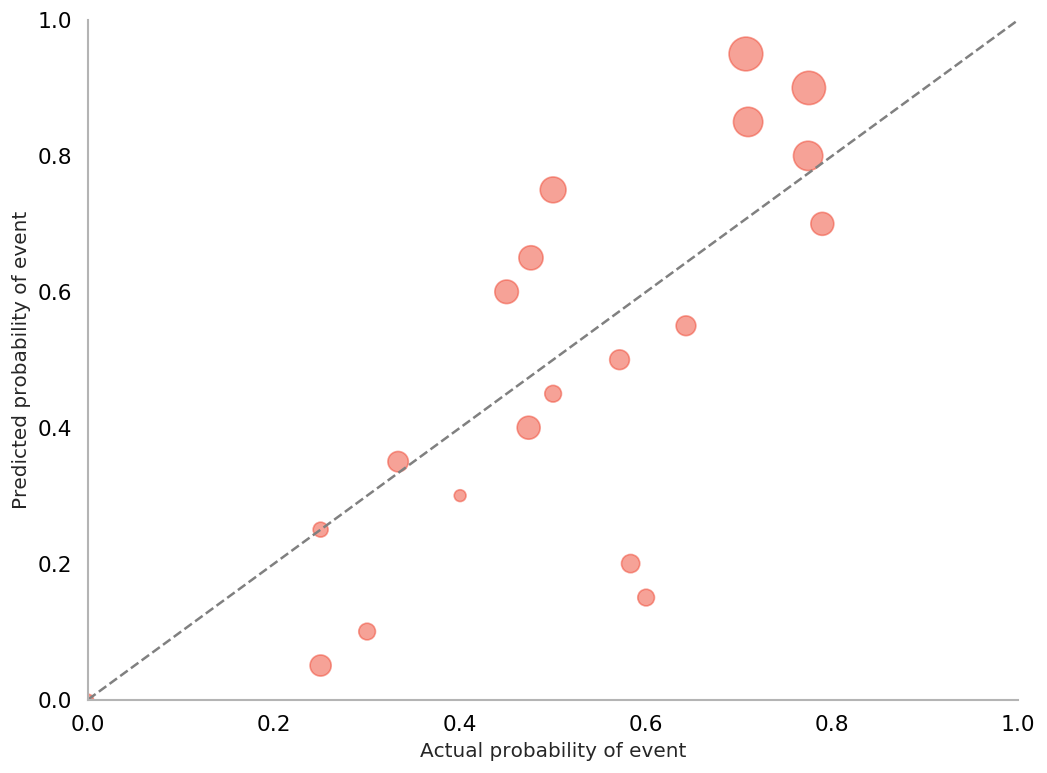

In [380]:
for_plotting = probability_plot(target_idx, predictions_df_valid)
for_plotting.head()

In [381]:
abs(for_plotting['predicted_prob'] - for_plotting['actual_prob']).mean()

0.14175325459597066

In [382]:
abs_error = abs(for_plotting['predicted_prob'] - for_plotting['actual_prob'])
proportions = for_plotting['n_games']/sum(for_plotting['n_games'])
sum(abs_error*proportions)

0.1475274725274725

# RF

In [383]:
from sklearn.ensemble import RandomForestClassifier

## Set hyperparams

In [384]:
from itertools import product

# Select hyperparams
n_estimators = [1000]
min_samples_split = [10, 50, 100, 200]

feature_set = ['feature_set_01', 'feature_set_02', 'feature_set_03', 'feature_set_04']

# Combinations of hyperparams
params_df = pd.DataFrame(product(n_estimators, min_samples_split, feature_set))
params_df.columns = ['n_estimators', 'min_samples_split', 'feature_set']
params_df

,n_estimators,min_samples_split,feature_set
0,1000,10,feature_set_01
1,1000,10,feature_set_02
2,1000,10,feature_set_03
3,1000,10,feature_set_04
4,1000,50,feature_set_01
5,1000,50,feature_set_02
6,1000,50,feature_set_03
7,1000,50,feature_set_04
8,1000,100,feature_set_01
9,1000,100,feature_set_02


In [449]:
df_raw.loc[543:544,:]

,index,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,home_result,away_result,home_pts_differential,away_pts_differential,total_pts,home_win_cumsum,home_game_number,home_win_percentage_cumsum,away_win_cumsum,away_game_number,away_win_percentage_cumsum,scored_1_home,allowed_1_home,result_1_home,pts_differential_1_home,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,time_delta_1_home,time_delta_cumsum_1_home,timezone_diff_1_home,timezone_diff_cumsum_1_home,scored_2_home,allowed_2_home,result_2_home,pts_differential_2_home,game_number_2_home,win_cumsum_2_home,win_percentage_cumsum_2_home,time_delta_2_home,time_delta_cumsum_2_home,timezone_diff_2_home,timezone_diff_cumsum_2_home,scored_3_home,allowed_3_home,result_3_home,pts_differential_3_home,game_number_3_home,win_cumsum_3_home,win_percentage_cumsum_3_home,time_delta_3_home,time_delta_cumsum_3_home,timezone_diff_3_home,timezone_diff_cumsum_3_home,scored_4_home,allowed_4_home,result_4_home,pts_differential_4_home,game_number_4_home,win_cumsum_4_home,win_percentage_cumsum_4_home,time_delta_4_home,time_delta_cumsum_4_home,timezone_diff_4_home,timezone_diff_cumsum_4_home,scored_1_away,allowed_1_away,result_1_away,pts_differential_1_away,game_number_1_away,win_cumsum_1_away,win_percentage_cumsum_1_away,time_delta_1_away,time_delta_cumsum_1_away,timezone_diff_1_away,timezone_diff_cumsum_1_away,scored_2_away,allowed_2_away,result_2_away,pts_differential_2_away,game_number_2_away,win_cumsum_2_away,win_percentage_cumsum_2_away,time_delta_2_away,time_delta_cumsum_2_away,timezone_diff_2_away,timezone_diff_cumsum_2_away,scored_3_away,allowed_3_away,result_3_away,pts_differential_3_away,game_number_3_away,win_cumsum_3_away,win_percentage_cumsum_3_away,time_delta_3_away,time_delta_cumsum_3_away,timezone_diff_3_away,timezone_diff_cumsum_3_away,scored_4_away,allowed_4_away,result_4_away,pts_differential_4_away,game_number_4_away,win_cumsum_4_away,win_percentage_cumsum_4_away,time_delta_4_away,time_delta_cumsum_4_away,timezone_diff_4_away,timezone_diff_cumsum_4_away,scored_1_home_home,allowed_1_home_home,result_1_home_home,pts_differential_1_home_home,game_number_1_home_home,win_cumsum_1_home_home,win_percentage_cumsum_1_home_home,time_delta_1_home_home,time_delta_cumsum_1_home_home,timezone_diff_1_home_home,timezone_diff_cumsum_1_home_home,scored_2_home_home,allowed_2_home_home,result_2_home_home,pts_differential_2_home_home,game_number_2_home_home,win_cumsum_2_home_home,win_percentage_cumsum_2_home_home,time_delta_2_home_home,time_delta_cumsum_2_home_home,timezone_diff_2_home_home,timezone_diff_cumsum_2_home_home,scored_3_home_home,allowed_3_home_home,result_3_home_home,pts_differential_3_home_home,game_number_3_home_home,win_cumsum_3_home_home,win_percentage_cumsum_3_home_home,time_delta_3_home_home,time_delta_cumsum_3_home_home,timezone_diff_3_home_home,timezone_diff_cumsum_3_home_home,scored_4_home_home,allowed_4_home_home,result_4_home_home,pts_differential_4_home_home,game_number_4_home_home,win_cumsum_4_home_home,win_percentage_cumsum_4_home_home,time_delta_4_home_home,time_delta_cumsum_4_home_home,timezone_diff_4_home_home,timezone_diff_cumsum_4_home_home,scored_1_away_away,allowed_1_away_away,result_1_away_away,pts_differential_1_away_away,game_number_1_away_away,win_cumsum_1_away_away,win_percentage_cumsum_1_away_away,time_delta_1_away_away,time_delta_cumsum_1_away_away,timezone_diff_1_away_away,timezone_diff_cumsum_1_away_away,scored_2_away_away,allowed_2_away_away,result_2_away_away,pts_differential_2_away_away,game_number_2_away_away,win_cumsum_2_away_away,win_percentage_cumsum_2_away_away,time_delta_2_away_away,time_delta_cumsum_2_away_away,timezone_diff_2_away_away,timezone_diff_cumsum_2_away_away,scored_3_away_away,allowed_3_away_away,result_3_away_away,pts_differential_3_away_away,game_number_3_away_away,win_cumsum_3_away_away,win_percentage_cumsum_3_away_away,time_delta_3_away_away,time_delta_cumsum_3_away_away,timezo

## Modeling

In [385]:
random_state_i = 0

In [387]:
# Train and score over hyperparameter combinations
experiments = {}

import progressbar
bar = progressbar.ProgressBar(maxval=len(params_df))
bar.start()

for i in range(len(params_df)):
    
    # Start recording time
    t0 = time.time()
    
    # Set params
    n_estimators_i = params_df.loc[i,'n_estimators']
    min_samples_split_i = params_df.loc[i,'min_samples_split']
    feature_set_i = params_df.loc[i,'feature_set']
    features_i = feature_selector(feature_set_i)
    
    # Transform df
    df_features_transformed = feature_transformer(df_raw, features_i, zscore=False)
    
    # Set cutoff dates
    cutoff_date_train = '2018-11-01'
    cutoff_date_test = '2019-01-01'
    cutoff_date_valid = '2019-02-15'

    # Make index list for easy searching later
    index_list = [
        'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
    ]

    # Get train, test, validation sets
    X_train, y_train, X_test, y_test, X_valid, y_valid = splitter(df_features_transformed, features_i, index_list, cutoff_date_train, cutoff_date_test, cutoff_date_valid)
    
    # Train model
    estimator = RandomForestClassifier(n_estimators=n_estimators_i, min_samples_split=min_samples_split_i, random_state=random_state_i)
    estimator.fit(X_train, y_train)
    
    # Score: train
    predictions_df_train, threshold_finder_train = scorer(X_train, y_train, estimator)

    # Score: test
    predictions_df_test, threshold_finder_test = scorer(X_test, y_test, estimator)
    
    # Score: valid
    predictions_df_valid, threshold_finder_valid = scorer(X_valid, y_valid, estimator)
    predictions_df_valid = predictions_df_valid.join(X_valid.reset_index().set_index('index'))
    
    # Compile results 
    results = {
        'train precision': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'train recall': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'train f1': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'train roc': roc_auc_score(predictions_df_train['actual'], predictions_df_train['pred_best_threshold']),
        'test precision': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'test recall': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'test f1': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'test roc': roc_auc_score(predictions_df_test['actual'], predictions_df_test['pred_best_threshold']),
        'valid precision': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'valid recall': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'valid f1': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'valid roc': roc_auc_score(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'])
    }
    
    # Compile experiment params
    params = {
        'n_estimators': n_estimators_i,
        'min_samples_split': min_samples_split_i,
        'feature_set': feature_set_i,
        'train size': len(X_train),
        'test size': len(X_test),
        'valid size': len(X_valid),
        'runtime': time.time() - t0
    }
    
    # Compile all
    experiments[i] = {
        'params': params,
        'results': results,
        'estimator': estimator,
        'predictions_df_valid': predictions_df_valid,
        'X_valid': X_valid
    }
    
    bar.update(i)

 93% (15 of 16) |######################  | Elapsed Time: 0:00:28 ETA:   0:00:01

In [433]:
# Compile experiment results
experiments_df = pd.DataFrame()
for i in experiments.keys():
    experiments_df = experiments_df.append(pd.DataFrame({**experiments[i]['params'], **experiments[i]['results']}, index=[i]))
# experiments_df.sort_values('valid precision', ascending=False)
experiments_df

,n_estimators,min_child_samples,feature_set,train size,test size,valid size,runtime,train precision,train recall,train f1,train roc,test precision,test recall,test f1,test roc,valid precision,valid recall,valid f1,valid roc
0,100,20,feature_set_01,438,318,364,0.222378,1.000000,0.984962,0.992424,0.992481,0.651042,0.686813,0.668449,0.597083,0.619266,0.636792,0.627907,0.545370
1,100,20,feature_set_02,383,318,364,0.203456,1.000000,0.982979,0.991416,0.991489,0.685864,0.719780,0.702413,0.639302,0.654378,0.669811,0.662005,0.588195
2,100,20,feature_set_03,383,318,364,0.229387,1.000000,1.000000,1.000000,1.000000,0.661458,0.697802,0.679144,0.609931,0.630137,0.650943,0.640371,0.559024
3,100,20,feature_set_04,383,318,364,0.178523,1.000000,0.978723,0.989247,0.989362,0.685864,0.719780,0.702413,0.639302,0.648402,0.669811,0.658933,0.581616
4,100,100,feature_set_01,438,318,364,0.161076,0.820611,0.808271,0.814394,0.767507,0.694737,0.725275,0.709677,0.649402,0.666667,0.679245,0.672897,0.602781
5,100,100,feature_set_02,383,318,364,0.154586,0.810345,0.800000,0.805139,0.751351,0.715789,0.747253,0.731183,0.675097,0.654378,0.669811,0.662005,0.588195
6,100,100,feature_set_03,383,318,364,0.172539,0.877729,0.855319,0.866379,0.833065,0.700000,0.730769,0.715054,0.655826,0.649770,0.665094,0.657343,0.582547
7,100,100,feature_set_04,383,318,364,0.172539,0.832599,0.804255,0.818182,0.773749,0.713542,0.752747,0.732620,0.674168,0.622727,0.646226,0.634259,0.550087
8,100,150,feature_set_01,438,318,364,0.152100,0.722433,0.714286,0.718336,0.644934,0.735751,0.780220,0.757333,0.702610,0.671171,0.702830,0.686636,0.611284
9,100,150,feature_set_02,383,318,364,0.154587,0.746725,0.727660,0.737069,0.667884,0.720207,0.763736,0.741333,0.683339,0.683036,0.721698,0.701835,0.627296


## Plotting predicted vs actual

In [389]:
# Get results df
target_idx =  12
predictions_df_valid = experiments[target_idx]['predictions_df_valid'].copy()

# Make new index for shap
predictions_df_valid.reset_index(inplace=True)
predictions_df_valid.rename(columns={'index': 'original_index'}, inplace=True)
predictions_df_valid.head()

,original_index,pred_proba,pred_default_threshold,pred_best_threshold,actual,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,result,home_kde_lag20_prob,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,game_number_1_away,win_percentage_cumsum_1_away,win_cumsum_1_away,agg_scored_4_lags_home,agg_allowed_4_lags_home,agg_pts_differential_4_lags_home,agg_total_pts_4_lags_home,agg_win_rate_4_lags_home,agg_time_delta_cumsum_4_lags_home,agg_timezone_diff_cumsum_4_lags_home,agg_scored_4_lags_away,agg_allowed_4_lags_away,agg_pts_differential_4_lags_away,agg_total_pts_4_lags_away,agg_win_rate_4_lags_away,agg_time_delta_cumsum_4_lags_away,agg_timezone_diff_cumsum_4_lags_away,agg_scored_4_lags_home_home,agg_allowed_4_lags_home_home,agg_pts_differential_4_lags_home_home,agg_total_pts_4_lags_home_home,agg_win_rate_4_lags_home_home,agg_scored_4_lags_away_away,agg_allowed_4_lags_away_away,agg_pts_differential_4_lags_away_away,agg_total_pts_4_lags_away_away,agg_win_rate_4_lags_away_away,agg_time_delta_cumsum_4_lags_away_away,agg_timezone_diff_cumsum_4_lags_away_away
0,866,0.539048,1.0,0,1.0,2018,february,2019-02-21,2019-02-21 22:30:00,Los Angeles Lakers,Houston Rockets,111,106,https://www.basketball-reference.com//boxscore...,1.0,0.3396,57.0,28.0,0.491228,57.0,0.578947,33.0,114.00,131.00,-17.00,245.00,0.25,9.958333,12.0,117.5,110.75,6.75,228.25,0.5,8.958333,2.0,109.25,118.25,-9.0,227.5,0.25,120.25,107.50,12.75,227.75,0.75,11.916667,5.0
1,867,0.603490,1.0,0,0.0,2018,february,2019-02-21,2019-02-21 19:30:00,Brooklyn Nets,Portland Trail Blazers,99,113,https://www.basketball-reference.com//boxscore...,0.0,0.3884,59.0,30.0,0.508475,57.0,0.596491,34.0,128.50,130.25,-1.75,258.75,0.50,8.979167,0.0,117.0,111.75,5.25,228.75,0.5,8.000000,4.0,114.25,121.25,-7.0,235.5,0.50,111.50,112.75,-1.25,224.25,0.25,20.958333,6.0
2,868,0.683709,1.0,1,1.0,2018,february,2019-02-21,2019-02-21 22:30:00,Golden State Warriors,Sacramento Kings,125,123,https://www.basketball-reference.com//boxscore...,1.0,0.6972,57.0,41.0,0.719298,57.0,0.526316,30.0,114.75,115.50,-0.75,230.25,0.75,7.000000,0.0,109.5,111.75,-2.25,221.25,0.5,8.958333,1.0,122.75,107.25,15.5,230.0,1.00,107.50,114.50,-7.00,222.00,0.25,23.229167,6.0
3,869,0.555201,1.0,0,1.0,2018,february,2019-02-21,2019-02-21 19:00:00,Cleveland Cavaliers,Phoenix Suns,111,98,https://www.basketball-reference.com//boxscore...,1.0,0.5205,58.0,12.0,0.206897,59.0,0.186441,11.0,110.50,119.00,-8.50,229.50,0.25,8.000000,3.0,101.5,121.00,-19.50,222.50,0.0,9.062500,1.0,110.00,116.50,-6.5,226.5,0.25,105.75,123.25,-17.50,229.00,0.00,17.041667,3.0
4,870,0.659774,1.0,1,1.0,2018,february,2019-02-21,2019-02-21 20:00:00,Milwaukee Bucks,Boston Celtics,98,97,https://www.basketball-reference.com//boxscore...,1.0,0.5893,57.0,43.0,0.754386,58.0,0.637931,37.0,105.75,101.50,4.25,207.25,0.75,6.958333,1.0,117.5,117.75,-0.25,235.25,0.5,8.020833,0.0,113.75,109.25,4.5,223.0,0.75,110.25,102.25,8.00,212.50,1.00,29.020833,0.0


N/A% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

,season,predicted_prob,actual_prob,n_games
0,2018,0.45,0.250000,240
1,2018,0.50,0.472222,360
2,2018,0.55,0.417722,790
3,2018,0.60,0.609524,1050
4,2018,0.65,0.752294,1090


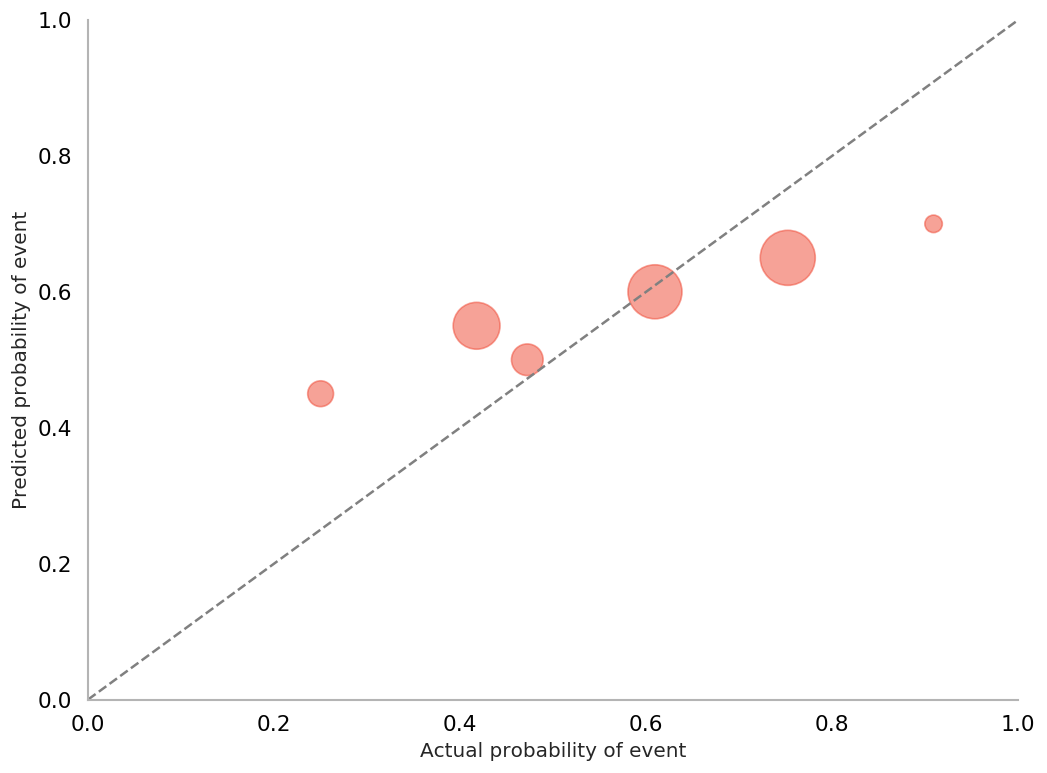

In [390]:
for_plotting = probability_plot(target_idx, predictions_df_valid)
for_plotting.head()

In [391]:
abs(for_plotting['predicted_prob'] - for_plotting['actual_prob']).mean()

0.1134940925644677

In [392]:
abs_error = abs(for_plotting['predicted_prob'] - for_plotting['actual_prob'])
proportions = for_plotting['n_games']/sum(for_plotting['n_games'])
sum(abs_error*proportions)

0.08434065934065939

## SHAP

In [393]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [394]:
# Get target estimator
target_estimator = experiments[target_idx]['estimator']
target_X_valid = experiments[target_idx]['X_valid']

In [395]:
%%time
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)

explainer = shap.TreeExplainer(target_estimator)
shap_values = explainer.shap_values(target_X_valid)

Wall time: 144 ms


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [396]:
explainer.expected_value[1]

0.6061872146118714

### Local explainability

#### Model got right

In [397]:
# Get results df 
results_correct = predictions_df_valid[(predictions_df_valid['result']==predictions_df_valid['pred_default_threshold']) & (abs(predictions_df_valid['pred_proba']-0.5)>=0.1)]
sample = results_correct.sample(1)
sample

,original_index,pred_proba,pred_default_threshold,pred_best_threshold,actual,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,result,home_kde_lag20_prob,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,game_number_1_away,win_percentage_cumsum_1_away,win_cumsum_1_away,agg_scored_4_lags_home,agg_allowed_4_lags_home,agg_pts_differential_4_lags_home,agg_total_pts_4_lags_home,agg_win_rate_4_lags_home,agg_time_delta_cumsum_4_lags_home,agg_timezone_diff_cumsum_4_lags_home,agg_scored_4_lags_away,agg_allowed_4_lags_away,agg_pts_differential_4_lags_away,agg_total_pts_4_lags_away,agg_win_rate_4_lags_away,agg_time_delta_cumsum_4_lags_away,agg_timezone_diff_cumsum_4_lags_away,agg_scored_4_lags_home_home,agg_allowed_4_lags_home_home,agg_pts_differential_4_lags_home_home,agg_total_pts_4_lags_home_home,agg_win_rate_4_lags_home_home,agg_scored_4_lags_away_away,agg_allowed_4_lags_away_away,agg_pts_differential_4_lags_away_away,agg_total_pts_4_lags_away_away,agg_win_rate_4_lags_away_away,agg_time_delta_cumsum_4_lags_away_away,agg_timezone_diff_cumsum_4_lags_away_away,bin,interval
182,1048,0.695097,1.0,1,1.0,2018,march,2019-03-17,2019-03-17 21:00:00,Houston Rockets,Minnesota Timberwolves,117,102,https://www.basketball-reference.com//boxscore...,1.0,0.678,69.0,43.0,0.623188,69.0,0.463768,32.0,106.0,101.75,4.25,207.75,0.75,7.0,0.0,111.25,118.75,-7.5,230.0,0.5,8.083333,2.0,109.25,101.25,8.0,210.5,0.75,110.5,129.75,-19.25,240.25,0.0,14.083333,5.0,13,0.65


In [398]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
target_result_index = sample.head(1).index
target_real_index = sample.head(1).original_index
shap.force_plot(explainer.expected_value[1], shap_values[1][target_result_index], target_X_valid.loc[target_real_index,:])

### Global explainability

In [399]:
fi = pd.DataFrame({'fi': estimator.feature_importances_})
fi['features'] = X_train.columns.tolist()
fi.sort_values('fi', ascending=False).head()

,fi,features
0,0.146749,home_projected_winloss
11,0.125851,win_percentage_cumsum_1_home_home
5,0.095539,win_percentage_cumsum_1_home
2,0.094967,home_kde_lag20_prob
17,0.071219,agg_pts_differential_4_lags_home


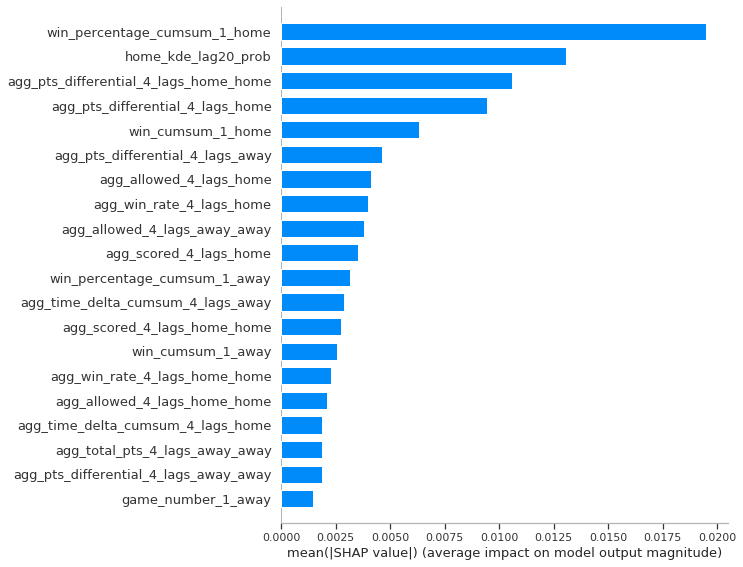

In [400]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], target_X_valid, plot_type="bar")

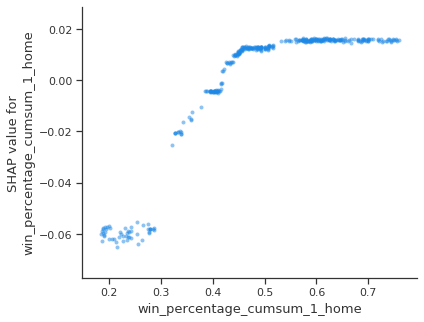

In [402]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("win_percentage_cumsum_1_home", shap_values[1], target_X_valid, interaction_index=None, alpha=0.5)

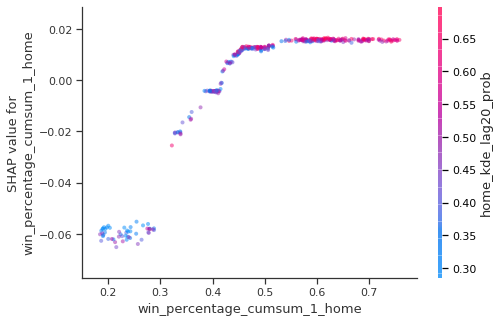

In [403]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("win_percentage_cumsum_1_home", shap_values[1], target_X_valid, interaction_index='home_kde_lag20_prob', alpha=0.5)

# LGBM

In [404]:
from lightgbm import LGBMClassifier

## Set hyperparams

In [405]:
from itertools import product

# Select hyperparams
n_estimators = [100, 500, 1000]
min_child_samples = [20, 100, 150]
feature_set = ['feature_set_01', 'feature_set_02', 'feature_set_03', 'feature_set_04']

# Combinations of hyperparams
params_df = pd.DataFrame(product(n_estimators, min_child_samples, feature_set))
params_df.columns = ['n_estimators', 'min_child_samples', 'feature_set']
params_df

,n_estimators,min_child_samples,feature_set
0,100,20,feature_set_01
1,100,20,feature_set_02
2,100,20,feature_set_03
3,100,20,feature_set_04
4,100,100,feature_set_01
5,100,100,feature_set_02
6,100,100,feature_set_03
7,100,100,feature_set_04
8,100,150,feature_set_01
9,100,150,feature_set_02


## Modeling

In [406]:
random_state_i = 0

In [407]:
# Train and score over hyperparameter combinations
experiments = {}

import progressbar
bar = progressbar.ProgressBar(maxval=len(params_df))
bar.start()

for i in range(len(params_df)):
    
    # Start recording time
    t0 = time.time()
    
    # Set params
    n_estimators_i = params_df.loc[i,'n_estimators']
    min_child_samples_i = params_df.loc[i,'min_child_samples']
    feature_set_i = params_df.loc[i,'feature_set']
    features_i = feature_selector(feature_set_i)
    
    # Transform df
    df_features_transformed = feature_transformer(df_raw, features_i, zscore=False)
    
    # Set cutoff dates
    cutoff_date_train = '2018-11-01'
    cutoff_date_test = '2019-01-01'
    cutoff_date_valid = '2019-02-15'

    # Make index list for easy searching later
    index_list = [
        'index', 'season', 'month', 'year_month_day', 'datetime', 'home_team', 'away_team', 'home_pts', 'away_pts', 'url_boxscore', 'result'
    ]

    # Get train, test, validation sets
    X_train, y_train, X_test, y_test, X_valid, y_valid = splitter(df_features_transformed, features_i, index_list, cutoff_date_train, cutoff_date_test, cutoff_date_valid)
    
    # Train model
    estimator = LGBMClassifier(n_estimators=n_estimators_i, min_child_samples=min_child_samples_i, random_state=random_state_i)
    estimator.fit(X_train, y_train)
    
    # Score: train
    predictions_df_train, threshold_finder_train = scorer(X_train, y_train, estimator)

    # Score: test
    predictions_df_test, threshold_finder_test = scorer(X_test, y_test, estimator)
    
    # Score: valid
    predictions_df_valid, threshold_finder_valid = scorer(X_valid, y_valid, estimator)
    predictions_df_valid = X_valid.reset_index().set_index('index').join(predictions_df_valid)
    
    # Compile results 
    results = {
        'train precision': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'train recall': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'train f1': classification_report(predictions_df_train['actual'], predictions_df_train['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'train roc': roc_auc_score(predictions_df_train['actual'], predictions_df_train['pred_best_threshold']),
        'test precision': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'test recall': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'test f1': classification_report(predictions_df_test['actual'], predictions_df_test['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'test roc': roc_auc_score(predictions_df_test['actual'], predictions_df_test['pred_best_threshold']),
        'valid precision': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['precision'],
        'valid recall': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['recall'],
        'valid f1': classification_report(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'], output_dict=True)['1.0']['f1-score'],
        'valid roc': roc_auc_score(predictions_df_valid['actual'], predictions_df_valid['pred_best_threshold'])
    }
    
    # Compile experiment params
    params = {
        'n_estimators': n_estimators_i,
        'min_child_samples': min_child_samples_i,
        'feature_set': feature_set_i,
        'train size': len(X_train),
        'test size': len(X_test),
        'valid size': len(X_valid),
        'runtime': time.time() - t0
    }
    
    # Compile all
    experiments[i] = {
        'params': params,
        'results': results,
        'estimator': estimator,
        'predictions_df_valid': predictions_df_valid,
        'X_valid': X_valid
    }
    
    bar.update(i)

 97% (35 of 36) |####################### | Elapsed Time: 0:00:08 ETA:   0:00:00

In [408]:
# Compile experiment results
experiments_df = pd.DataFrame()
for i in experiments.keys():
    experiments_df = experiments_df.append(pd.DataFrame({**experiments[i]['params'], **experiments[i]['results']}, index=[i]))
experiments_df.sort_values('valid precision', ascending=False).head()

,n_estimators,min_child_samples,feature_set,train size,test size,valid size,runtime,train precision,train recall,train f1,train roc,test precision,test recall,test f1,test roc,valid precision,valid recall,valid f1,valid roc
10,100,150,feature_set_03,383,318,364,0.170531,0.774336,0.744681,0.759219,0.700043,0.709845,0.752747,0.730667,0.670491,0.684444,0.726415,0.704805,0.629655
9,100,150,feature_set_02,383,318,364,0.154587,0.746725,0.727660,0.737069,0.667884,0.720207,0.763736,0.741333,0.683339,0.683036,0.721698,0.701835,0.627296
21,500,150,feature_set_02,383,318,364,0.203456,0.773504,0.770213,0.771855,0.706052,0.746032,0.774725,0.760108,0.710892,0.671233,0.693396,0.682135,0.609856
8,100,150,feature_set_01,438,318,364,0.152100,0.722433,0.714286,0.718336,0.644934,0.735751,0.780220,0.757333,0.702610,0.671171,0.702830,0.686636,0.611284
22,500,150,feature_set_03,383,318,364,0.202963,0.834061,0.812766,0.823276,0.778005,0.720207,0.763736,0.741333,0.683339,0.668203,0.683962,0.675991,0.605139


## Plotting predicted vs actual

In [419]:
# Get results df
target_idx =  9
predictions_df_valid = experiments[target_idx]['predictions_df_valid'].copy()

# Make new index for shap
predictions_df_valid.reset_index(inplace=True)
predictions_df_valid.rename(columns={'index': 'original_index'}, inplace=True)
predictions_df_valid.head()

,original_index,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,result,home_kde_lag20_prob,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,game_number_1_away,win_cumsum_1_away,win_percentage_cumsum_1_away,game_number_1_home_home,win_cumsum_1_home_home,win_percentage_cumsum_1_home_home,game_number_1_away_away,win_cumsum_1_away_away,win_percentage_cumsum_1_away_away,agg_scored_4_lags_home,agg_allowed_4_lags_home,agg_pts_differential_4_lags_home,agg_total_pts_4_lags_home,agg_win_rate_4_lags_home,agg_time_delta_cumsum_4_lags_home,agg_timezone_diff_cumsum_4_lags_home,agg_scored_4_lags_away,agg_allowed_4_lags_away,agg_pts_differential_4_lags_away,agg_total_pts_4_lags_away,agg_win_rate_4_lags_away,agg_time_delta_cumsum_4_lags_away,agg_timezone_diff_cumsum_4_lags_away,agg_scored_4_lags_home_home,agg_allowed_4_lags_home_home,agg_pts_differential_4_lags_home_home,agg_total_pts_4_lags_home_home,agg_win_rate_4_lags_home_home,agg_scored_4_lags_away_away,agg_allowed_4_lags_away_away,agg_pts_differential_4_lags_away_away,agg_total_pts_4_lags_away_away,agg_win_rate_4_lags_away_away,agg_time_delta_cumsum_4_lags_away_away,agg_timezone_diff_cumsum_4_lags_away_away,pred_proba,pred_default_threshold,pred_best_threshold,actual
0,866,2018,february,2019-02-21,2019-02-21 22:30:00,Los Angeles Lakers,Houston Rockets,111,106,https://www.basketball-reference.com//boxscore...,1.0,0.3396,57.0,28.0,0.491228,57.0,33.0,0.578947,51.0,26.0,0.509804,57.0,33.0,0.578947,114.00,131.00,-17.00,245.00,0.25,9.958333,12.0,117.5,110.75,6.75,228.25,0.5,8.958333,2.0,109.25,118.25,-9.0,227.5,0.25,120.25,107.50,12.75,227.75,0.75,11.916667,5.0,0.527052,1.0,0,1.0
1,867,2018,february,2019-02-21,2019-02-21 19:30:00,Brooklyn Nets,Portland Trail Blazers,99,113,https://www.basketball-reference.com//boxscore...,0.0,0.3884,59.0,30.0,0.508475,57.0,34.0,0.596491,57.0,29.0,0.508772,56.0,33.0,0.589286,128.50,130.25,-1.75,258.75,0.50,8.979167,0.0,117.0,111.75,5.25,228.75,0.5,8.000000,4.0,114.25,121.25,-7.0,235.5,0.50,111.50,112.75,-1.25,224.25,0.25,20.958333,6.0,0.580192,1.0,0,0.0
2,868,2018,february,2019-02-21,2019-02-21 22:30:00,Golden State Warriors,Sacramento Kings,125,123,https://www.basketball-reference.com//boxscore...,1.0,0.6972,57.0,41.0,0.719298,57.0,30.0,0.526316,56.0,41.0,0.732143,57.0,30.0,0.526316,114.75,115.50,-0.75,230.25,0.75,7.000000,0.0,109.5,111.75,-2.25,221.25,0.5,8.958333,1.0,122.75,107.25,15.5,230.0,1.00,107.50,114.50,-7.00,222.00,0.25,23.229167,6.0,0.782045,1.0,1,1.0
3,869,2018,february,2019-02-21,2019-02-21 19:00:00,Cleveland Cavaliers,Phoenix Suns,111,98,https://www.basketball-reference.com//boxscore...,1.0,0.5205,58.0,12.0,0.206897,59.0,11.0,0.186441,58.0,12.0,0.206897,59.0,11.0,0.186441,110.50,119.00,-8.50,229.50,0.25,8.000000,3.0,101.5,121.00,-19.50,222.50,0.0,9.062500,1.0,110.00,116.50,-6.5,226.5,0.25,105.75,123.25,-17.50,229.00,0.00,17.041667,3.0,0.665031,1.0,1,1.0
4,870,2018,february,2019-02-21,2019-02-21 20:00:00,Milwaukee Bucks,Boston Celtics,98,97,https://www.basketball-reference.com//boxscore...,1.0,0.5893,57.0,43.0,0.754386,58.0,37.0,0.637931,55.0,41.0,0.745455,57.0,36.0,0.631579,105.75,101.50,4.25,207.25,0.75,6.958333,1.0,117.5,117.75,-0.25,235.25,0.5,8.020833,0.0,113.75,109.25,4.5,223.0,0.75,110.25,102.25,8.00,212.50,1.00,29.020833,0.0,0.674502,1.0,1,1.0


N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

,season,predicted_prob,actual_prob,n_games
0,2018,0.35,0.600000,50
1,2018,0.40,0.230769,130
2,2018,0.45,0.387097,310
3,2018,0.50,0.480000,500
4,2018,0.55,0.471698,530


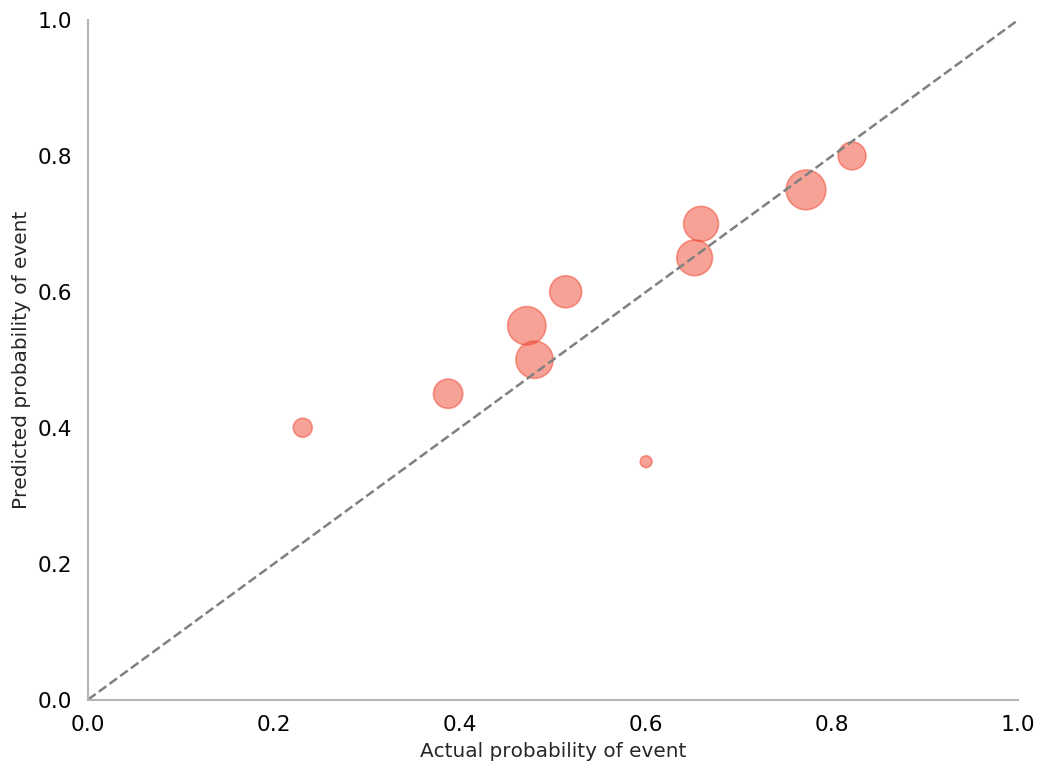

In [420]:
for_plotting = probability_plot(target_idx, predictions_df_valid)
for_plotting.head()

In [421]:
abs(for_plotting['predicted_prob'] - for_plotting['actual_prob']).mean()

0.07533637682587042

In [422]:
abs_error = abs(for_plotting['predicted_prob'] - for_plotting['actual_prob'])
proportions = for_plotting['n_games']/sum(for_plotting['n_games'])
sum(abs_error*proportions)

0.04807692307692308

## SHAP

In [423]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [424]:
# Get target estimator
target_estimator = experiments[target_idx]['estimator']
target_X_valid = experiments[target_idx]['X_valid']

In [425]:
%%time
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)

explainer = shap.TreeExplainer(target_estimator)
shap_values = explainer.shap_values(target_X_valid)

Wall time: 125 ms


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [426]:
explainer.expected_value[1]

0.4925411121430673

### Local explainability

#### Model got right

In [427]:
# Get results df 
results_correct = predictions_df_valid[(predictions_df_valid['result']==predictions_df_valid['pred_default_threshold']) & (abs(predictions_df_valid['pred_proba']-0.5)>=0.1)]
sample = results_correct.sample(1)
sample

,original_index,season,month,year_month_day,datetime,home_team,away_team,home_pts,away_pts,url_boxscore,result,home_kde_lag20_prob,game_number_1_home,win_cumsum_1_home,win_percentage_cumsum_1_home,game_number_1_away,win_cumsum_1_away,win_percentage_cumsum_1_away,game_number_1_home_home,win_cumsum_1_home_home,win_percentage_cumsum_1_home_home,game_number_1_away_away,win_cumsum_1_away_away,win_percentage_cumsum_1_away_away,agg_scored_4_lags_home,agg_allowed_4_lags_home,agg_pts_differential_4_lags_home,agg_total_pts_4_lags_home,agg_win_rate_4_lags_home,agg_time_delta_cumsum_4_lags_home,agg_timezone_diff_cumsum_4_lags_home,agg_scored_4_lags_away,agg_allowed_4_lags_away,agg_pts_differential_4_lags_away,agg_total_pts_4_lags_away,agg_win_rate_4_lags_away,agg_time_delta_cumsum_4_lags_away,agg_timezone_diff_cumsum_4_lags_away,agg_scored_4_lags_home_home,agg_allowed_4_lags_home_home,agg_pts_differential_4_lags_home_home,agg_total_pts_4_lags_home_home,agg_win_rate_4_lags_home_home,agg_scored_4_lags_away_away,agg_allowed_4_lags_away_away,agg_pts_differential_4_lags_away_away,agg_total_pts_4_lags_away_away,agg_win_rate_4_lags_away_away,agg_time_delta_cumsum_4_lags_away_away,agg_timezone_diff_cumsum_4_lags_away_away,pred_proba,pred_default_threshold,pred_best_threshold,actual,bin,interval
355,1221,2018,april,2019-04-10,2019-04-10 20:00:00,Philadelphia 76ers,Chicago Bulls,125,109,https://www.basketball-reference.com//boxscore...,1.0,0.6702,81.0,50.0,0.617284,81.0,22.0,0.271605,79.0,49.0,0.620253,79.0,22.0,0.278481,114.75,119.0,-4.25,233.75,0.25,7.958333,1.0,100.5,109.75,-9.25,210.25,0.25,10.0,3.0,121.5,116.75,4.75,238.25,0.75,109.75,110.0,-0.25,219.75,0.5,17.041667,6.0,0.769874,1.0,1,1.0,15,0.75


In [428]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
target_result_index = sample.head(1).index
target_real_index = sample.head(1).original_index
shap.force_plot(explainer.expected_value[1], shap_values[1][target_result_index], target_X_valid.loc[target_real_index,:], link="logit")

### Global explainability

In [429]:
fi = pd.DataFrame({'fi': estimator.feature_importances_})
fi['features'] = X_train.columns.tolist()
fi.sort_values('fi', ascending=False).head()

,fi,features
2,87,home_kde_lag20_prob
34,85,agg_scored_4_lags_away_away
14,73,win_percentage_cumsum_1_away_away
11,72,win_percentage_cumsum_1_home_home
37,53,agg_total_pts_4_lags_away_away


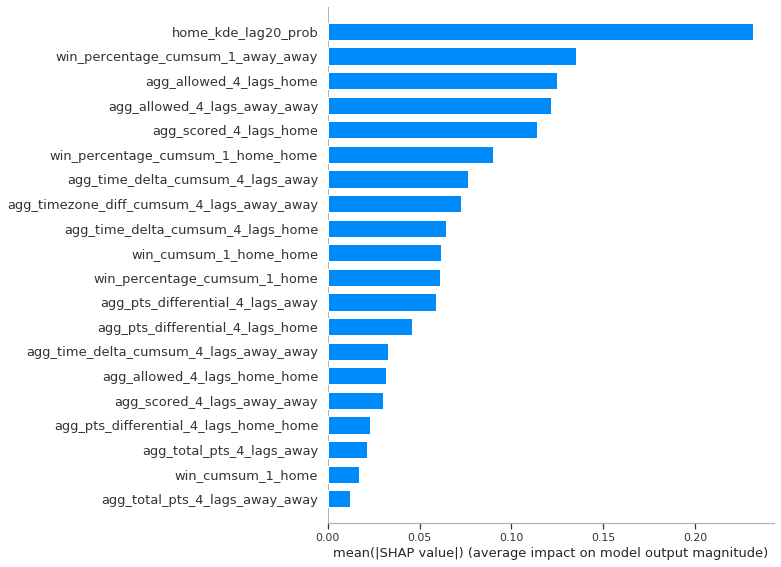

In [430]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], target_X_valid, plot_type="bar")

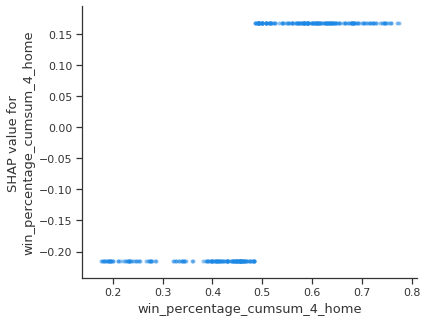

In [259]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("win_percentage_cumsum_4_home", shap_values[1], target_X_valid, interaction_index=None, alpha=0.5)

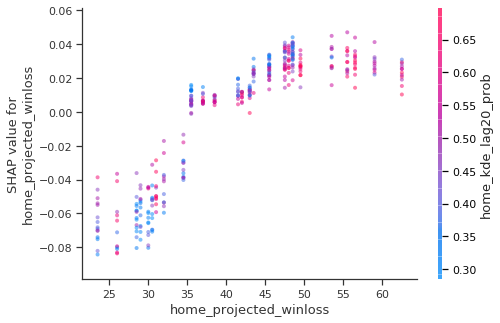

In [232]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("home_projected_winloss", shap_values[1], target_X_valid, interaction_index='home_kde_lag20_prob', alpha=0.5)